# Tutorial exercise 5 - simulating GTT

#### In this tutorial we will integrate the previous exercises in order to simulate glucose tolerance test

In [1]:
from sympy import * # importing sympy to python
import numpy as np
from matplotlib import pyplot as plt

#### The differential equations for glucose and insulin are

$\frac{dG}{dt} = m - sIG$

$\frac{dI}{dt} = qBf(G) - \gamma I$


In this exmaple, we will use $f(G) = \frac{G^2}{1+G^2}$

#### In order to simulate, we have to:

- Provide a numeric value for all the parameters

    we will use $q=1, B=1, s=1, \gamma=1, m=0.5$


In [4]:
q       = 1
B       = 1
s       = 1
gamma   = 1
m       = 0.5

- Decide on the length of the simualtion, $L$, and the size of the time steps, $dt$

    we will use $L = 15, dt = 0.1$ 

In [5]:
dt      = 0.1
L       = 15
t_range = np.arange(0,L,dt)

- Choose inital condition - the values of $I$ and $G$ in the start of the simulation

    We will start the simulation at steady state
    
    We can again find the steady state using 'solve'
   

In [6]:
I,G     = symbols('I,G',positive=True)
dG      = m                 - s*I*G
dI      = q*B*G**2/(1+G**2) - gamma*I

Gst_numeric,Ist_numeric = solve([dG,dI],[G,I])[0]

#### Starting at steady state, we loop over the time-steps, calculate the change in both $G$ and $I$ and update their values

We simulate the glucose tolerance test by adding a glucose input term $m(t)$ that rises and falls with time: $m(t) = 1+e^{-(t-5)^2}$

In [7]:
t_range  = np.arange(0,L,dt)
Gsol     = []
Isol     = []

G        = Gst_numeric
I        = Ist_numeric

for t in t_range:
    
    mt = 0.5+np.e**(-(t-5)**2)
    
    dG = mt                - s*I*G
    dI = q*B*G**2/(1+G**2) - gamma*I
    
    G  = G + dG*dt
    I  = I + dI*dt

    Gsol.append(G)
    Isol.append(I)

Text(0.5, 0, 'time, t')

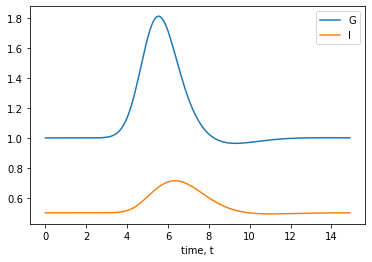

In [8]:
plt.plot(t_range,Gsol)
plt.plot(t_range,Isol)
plt.legend(['G','I'])
plt.xlabel('time, t')

We can divide each variable by its steady state to show their relative change

Text(0.5, 0, 'time, t')

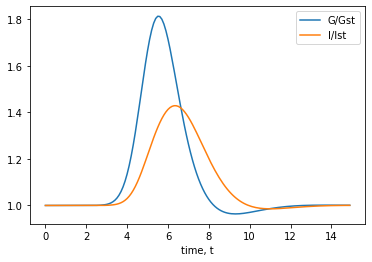

In [9]:
plt.plot(t_range,np.array(Gsol)/Gst_numeric)
plt.plot(t_range,np.array(Isol)/Ist_numeric)
plt.legend(['G/Gst','I/Ist'])
plt.xlabel('time, t')

## Next, we will use a different method to integrate the ODEs, using scipy's 'odeint' function (ordinary differntial equation integrator)

#### Before we dive in to the code of the simualtion, lets get familiar with two new sympy functions: 'Matrix' and 'lambdify'

We use 'Matrix' in order to hold all three equations in one variable

In [10]:
I,G,m,s,q,B,gamma = symbols('I,G,m,s,q,B,\gamma',positive=True)

dG      = m                 - s*I*G
dI      = q*B*G**2/(1+G**2) - gamma*I
model   = Matrix([dG,dI])
display(model)

Matrix([
[                    -G*I*s + m],
[B*G**2*q/(G**2 + 1) - I*\gamma]])

We store values for the parameters within a dictionary

In [11]:
parameter_values    = {gamma:1,m:0.5,q:1,s:1,B:1} 

We use '.subs()' in order to substitute the parameters with the numerical values:

In [12]:
display(model.subs(parameter_values))

Matrix([
[         -G*I + 0.5],
[G**2/(G**2 + 1) - I]])

We use solve in order to find the steady state.

Because we gave numercial values for the parameters, the steady state will also be numeric

We will use this steady state as the intial condition

In [13]:
ic   = solve(model.subs(parameter_values),[G,I])[0]

### Next, we want a method to calulate $(dG,dI)$ for a given set of parameter $(G,I)$

we can use '.subs()' in order to calculate the differential equations

For example, if G=2, I=1, we can find dG,dI:

In [14]:
display(model.subs(parameter_values).subs({G:2,I:1}))

Matrix([
[-1.5],
[-1/5]])

#### However, there is a better way: 'lambdify'

lambdify takes our symbolic model and returns a python function:

* The first argument is a list of the parameters that we want to use as input for the function
* The second argument is a symbolic expression to turn into a function

In the following example, we use lambdify in order to make a function 'func' that substracts 5 from a number:
* $G - 5$ is the mathematical expression
* $G$ is the input for the function

In [15]:
func = lambdify(G,G-5)

When we pass 'func' the input $7$, it will return the solution of $G-5$ for $G=7$.

In [16]:
func(7)

2

'lambdify' can get more than one parameter, for example:

In [17]:
func = lambdify([G,I],G-I)

When we pass 'func' the inputs $7,2$, it will return the solution of $G-I$ for $G=7,I=2$.

In [18]:
func(7,2)

5

In addition, 'lambdify' can get more than expression:

In [19]:
func = lambdify([G,I],[G-I,G+I])

When we pass 'func' the inputs $7,2$, it will return two solution. The first is for $G-I$, the sconde is for $G+I$

In [20]:
func(7,2)

[5, 9]

### Now we are ready to use 'lambdify' to calulate $(dG,dI)$ for a given set of parameter $(G,I)$

'model.subs(parameter_values)' holds three symbolic expressions (𝑑𝐺,𝑑𝐼,𝑑𝐵) with numeric values for the parameters

In [21]:
display(model.subs(parameter_values))

Matrix([
[         -G*I + 0.5],
[G**2/(G**2 + 1) - I]])

In [22]:
model_func = lambdify([G,I],model.subs(parameter_values))

For example, if G=2, I=1, We can find dG,dI:

In [23]:
model_func(2,1)

array([[-1.5],
       [-0.2]])

usually we add '.flat[:]' to get the result in a 1-d array:

In [24]:
model_func(2,1).flat[:]

array([-1.5, -0.2])

#### Altough it seems that we can get the same results with .subs() and lambdify,  using lambdify is much faster. But more importently, it enables us to pass our model into other python libraries.

### Now we will see how to use lambdify in order to simulate the model:
#### We build a simulation function around 'model_func'

The simulation function must have the following form:

First input  - list of the variables in the model $(G,I)$

Second input - time $t$

Returns      - list of the calculated change in each variable per $dt$ $(dG,dI)$

#### A generic form for this function is:

In [25]:
def sim(y,t):
    G,I    = y                         # y is the list of the varibales
    dG,dI = model_func(G,I).flat[:]
    return dG,dI

#### Like before, we start by defining the time-course of the simualtion

In [26]:
L          = 20
dt         = 0.1
sim_time   = np.arange(0,L,dt)

To simulate the model, we use 'odeint' (ordinary differntial equation integrator)

In [27]:
from scipy.integrate import odeint

'odeint' gets the simulation function, the intial conditions and the time-course

In [28]:
result = odeint(sim,ic,sim_time)

I store the simulation result in pandas DataFrame because we can plot it easly

In [29]:
import pandas as pd

<AxesSubplot:>

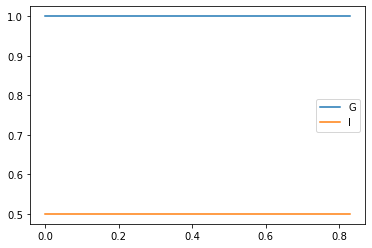

In [30]:
result = pd.DataFrame(result,columns=['G','I'],index=sim_time/24)
result.plot()

In the simulation above nothing changed, we started at steady state thus the system isn't changeing

### We integrate the steps above and simulate the GTT using odeint

<AxesSubplot:>

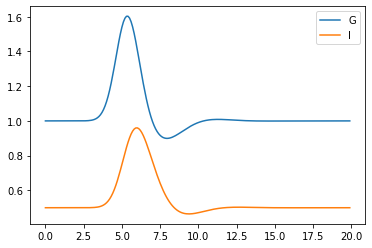

In [33]:
dG                = m                 - s*I*G
dI                = q*B*G**2/(1+G**2) - gamma*I
parameter_values  = {gamma:1,q:1,s:1,B:1} 

model             = Matrix([dG,dI])
ic                = solve(model.subs(parameter_values).subs(m,0.5),[G,I])[0]
model_func        = lambdify([G,I,m],model.subs(parameter_values))

def sim(y,t):
    G,I   = y
    mt    = 0.5+np.e**(-(t-5)**2)
    dG,dI = model_func(G,I,mt).flat[:]
    return dG,dI 

L          = 20
dt         = 0.1
sim_time   = np.arange(0,L,dt)
result     = pd.DataFrame(odeint(sim,ic,sim_time),columns=['G','I'],index=sim_time)

result.plot()

#### We can also wrap this into a function

In [34]:
def simulate_GTT(dG,dI,parameter_values):
    model             = Matrix([dG,dI])
    ic                = solve(model.subs(parameter_values).subs(m,0.5),[G,I])[0]
    model_func        = lambdify([G,I,m],model.subs(parameter_values))

    def sim(y,t):
        G,I   = y
        mt    = 0.5+np.e**(-(t-5)**2)
        dG,dI = model_func(G,I,mt).flat[:]
        return dG,dI 

    L          = 20
    dt         = 0.1
    sim_time   = np.arange(0,L,dt)
    result     = pd.DataFrame(odeint(sim,ic,sim_time),columns=['G','I'],index=sim_time)

    result.plot()

### We can easliy change some assumption of the model and observe the dynamics without calculating the steady state or writing another code

Here we simulate the model using $f(G) = \frac{G^2}{1+G^2}$

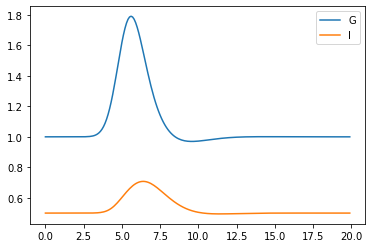

In [39]:
dG  = m                 - s*I*G
dI  = q*B*G**2/(1+G**2) - gamma*I
simulate_GTT(dG,dI,{gamma:1,q:1,s:1,B:1} )

Here we simulate the model using $f(G) = G$

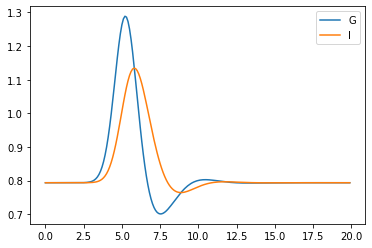

In [43]:
dG  = m     - s*I*G
dI  = q*B*G - gamma*I
simulate_GTT(dG,dI,{gamma:1,q:1,s:1,B:1} )